In [1]:
import pandas as pd
import numpy as np
import os
import time
import sklearn
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import xgboost
from xgboost import XGBClassifier
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import Adam, SGD
from keras import regularizers
import tensorflow as tf
from tensorflow import set_random_seed
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import h5py
from keras.models import model_from_json
import tensorflow as tf
import random as rn
from tensorflow import set_random_seed

np.random.seed(54321)
rn.seed(54321)
set_random_seed(54321)
os.environ['PYTHONHASHSEED'] = '54321'

Using TensorFlow backend.


In [2]:
keras.__version__

'2.2.2'

In [3]:
tf.__version__

'1.10.1'

In [5]:
help(EarlyStopping) #Does not include restore_best_weights as an argument

Help on class EarlyStopping in module keras.callbacks:

class EarlyStopping(Callback)
 |  Stop training when a monitored quantity has stopped improving.
 |  
 |  # Arguments
 |      monitor: quantity to be monitored.
 |      min_delta: minimum change in the monitored quantity
 |          to qualify as an improvement, i.e. an absolute
 |          change of less than min_delta, will count as no
 |          improvement.
 |      patience: number of epochs with no improvement
 |          after which training will be stopped.
 |      verbose: verbosity mode.
 |      mode: one of {auto, min, max}. In `min` mode,
 |          training will stop when the quantity
 |          monitored has stopped decreasing; in `max`
 |          mode it will stop when the quantity
 |          monitored has stopped increasing; in `auto`
 |          mode, the direction is automatically inferred
 |          from the name of the monitored quantity.
 |      baseline: Baseline value for the monitored quantity to reach

In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
data_path = '/home/mvkrein/etf_model/data'
etf_data_file = os.path.join(data_path,'etf_new_var_20180910.csv')
etf_data = pd.read_csv(etf_data_file,index_col=0)

In [4]:
etf_study_file = os.path.join(data_path,'ETF_list_min_6yr_history.csv')
etf_list = pd.read_csv(etf_study_file,index_col=0)
etf_data.sort_values(['Date','sym'],ascending=True,inplace=True)
etf_data.reset_index(drop=True,inplace=True)

In [5]:
drop_columns = ['Date','sym','p', 'v', 'p_L05', 'v_L05', 'p_L10', 'v_L10', 'p_L21', 'v_L21', 'p_L42', 'v_L42', 'p_L63', \
                'v_L63', 'p_L84', 'v_L84', 'p_L126', 'v_L126', 'p_L189', 'v_L189', 'p_L252', 'v_L252',\
                'p_L-21', 'v_L-21', 'delta_p_L05', 'delta_p_L10', 'delta_p_L21', 'delta_p_L42', 'delta_p_L63', \
                'delta_p_L84', 'delta_p_L126', 'delta_p_L189', 'delta_p_L252', 'delta_p_L-21', 'delta_v_L05',\
                'delta_v_L10', 'delta_v_L21', 'delta_v_L42', 'delta_v_L63', 'delta_v_L84', 'delta_v_L126', \
                'delta_v_L189', 'delta_v_L252','rank_p_L-21', 'ivv_delta_p_L-21', 'target']

rank_col = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
            'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']

In [6]:
all_columns = list(etf_data.columns)

In [7]:
include_columns = [x for x in all_columns if x not in drop_columns]
# include_columns = ['rank_p_L05','rank_p_L10','rank_p_L21','rank_p_L42',\
#             'rank_p_L63','rank_p_L84','rank_p_L126','rank_p_L189','rank_p_L252']
# include_columns = ['rank_p_L05','rank_p_L21','rank_p_L42','rank_p_L252']

In [8]:
len(include_columns)

360

In [9]:
dates = list(etf_data['Date'].unique())
# dates[1671]

In [21]:
len(dates)

1676

In [18]:
# determine index for specific date in case a restart is necessary
for i in range(0,len(dates)):
    if dates[i]=='2017-08-07':
        print (i,dates[i])


1407 2017-08-07


In [10]:
symbols = etf_list['Symbol'].unique()

In [11]:
len(symbols)

153

In [12]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
#     axs[0].legend(['train'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
#     axs[1].legend(['train'], loc='best')
    plt.show()

In [13]:
def func_acc(test_x, test_y, threshold=0.5):
    result = np.ravel(model.predict(x_test_nmpy))
    predicted_class = (result>=threshold).astype(int)
    true_class = np.ravel(y_test_nmpy)
    num_correct = np.sum(predicted_class == true_class) 
    func_acc = float(num_correct)/len(result)
    return (func_acc)

In [22]:
#Each year has 252 trading dates.  Need two years to fully develop variables.
dt1 = 504  #This is the first day that all variables are developed
# make all dates relative to dt1
# for one year training - add 252
# to evaluate for one month outside the training window - add 273
# to predict for the first day outside of the evaluation window (have to lag 21) - add 294
dt_end = (len(dates) - 273 - 21) - 1
# dt_end = dt1 + 1 #use this for testing
etf_predict_file = os.path.join(data_path,'etf_pred_DL_20180926_do02_deep2.csv')
dt2 = 1407 - 273 #restart on '2017-08-07' -- use dt2 to restart when the job was interrupted

In [24]:
model = Sequential()
model.add(Dense(360, input_dim=360,kernel_initializer=init,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(360,kernel_initializer=init,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(360,kernel_initializer=init,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(90,kernel_initializer=init,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,kernel_initializer=init,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,kernel_initializer=init,activation='sigmoid'))
#         Adm = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0)
Adm = Adam(lr=0.0005)
# Compile model
model.compile(loss='binary_crossentropy', optimizer=Adm, metrics=['accuracy'])
#         model_file='/home/mvkrein/etf_model/code/weights-20180925_deep02-{epoch:02d}-{val_acc:.4f}.h5'
earlyStopping = EarlyStopping(monitor='val_acc', patience=100, verbose=0, mode='auto')
mcp_save = ModelCheckpoint(model_file, save_best_only=True,monitor='val_acc', mode='auto')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.8, patience=30, verbose=1, mode='auto')

Building model to predict for  2017-08-07
Train on 35343 samples, validate on 3213 samples
Epoch 1/1000
35343/35343 [==============================] - 2s 56us/step - loss: 0.8760 - acc: 0.4977 - val_loss: 0.7991 - val_acc: 0.4535
Epoch 2/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.7959 - acc: 0.5023 - val_loss: 0.7828 - val_acc: 0.4721
Epoch 3/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.7710 - acc: 0.4969 - val_loss: 0.7528 - val_acc: 0.4379
Epoch 4/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.7225 - acc: 0.5109 - val_loss: 0.7350 - val_acc: 0.3772
Epoch 5/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.7020 - acc: 0.5193 - val_loss: 0.7314 - val_acc: 0.3626
Epoch 6/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6991 - acc: 0.5200 - val_loss: 0.7290 - val_acc: 0.3763
Epoch 7/1000
35343/35343 [==============================] - 1s 39us/step - 


Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.00020480002276599408.
Epoch 59/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6284 - acc: 0.6427 - val_loss: 0.7662 - val_acc: 0.3838
Epoch 60/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6275 - acc: 0.6445 - val_loss: 0.7665 - val_acc: 0.3884
Epoch 61/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6262 - acc: 0.6455 - val_loss: 0.7626 - val_acc: 0.3984
Epoch 62/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.6255 - acc: 0.6480 - val_loss: 0.7595 - val_acc: 0.4027
Epoch 63/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6237 - acc: 0.6506 - val_loss: 0.7586 - val_acc: 0.4018
Epoch 64/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.6208 - acc: 0.6531 - val_loss: 0.7620 - val_acc: 0.4037
Epoch 65/1000
35343/35343 [==============================] - 1s 39us/step - lo

Epoch 117/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.5601 - acc: 0.7139 - val_loss: 0.7879 - val_acc: 0.4500
Epoch 118/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5580 - acc: 0.7171 - val_loss: 0.7834 - val_acc: 0.4578

Epoch 00118: ReduceLROnPlateau reducing learning rate to 0.0001310720108449459.
Epoch 119/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5573 - acc: 0.7165 - val_loss: 0.7754 - val_acc: 0.4728
Epoch 120/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.5565 - acc: 0.7170 - val_loss: 0.7713 - val_acc: 0.4787
Epoch 121/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5561 - acc: 0.7170 - val_loss: 0.7773 - val_acc: 0.4700
Epoch 122/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5547 - acc: 0.7199 - val_loss: 0.7871 - val_acc: 0.4594
Epoch 123/1000
35343/35343 [==============================] - 1s 40us/ste

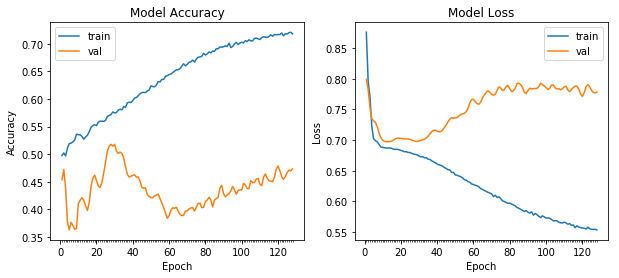

Accuracy using best model is: 0.33
Confusion Matrix Threshold: 0.509134829044342
Model Eval Results:
*****************************
Confusion Matrix:
 [[48  3]
 [90 12]]
Precision: 0.8
Model Top Five Picks
 Avg rtn top 5: 0.0182
   true_value  pred_value  mkt_return   returns
0         1.0    0.571808   -0.003647  0.019709
1         1.0    0.541757   -0.003647  0.019033
2         1.0    0.540429   -0.003647  0.053803
3         1.0    0.531587   -0.003647 -0.001242
4         1.0    0.519580   -0.003647 -0.000258
Model 2nd Five Picks
 Avg rtn 2nd 5: 0.0088
   true_value  pred_value  mkt_return   returns
5         1.0    0.518505   -0.003647  0.024945
6         0.0    0.517940   -0.003647 -0.003724
7         1.0    0.516538   -0.003647  0.010811
8         1.0    0.516304   -0.003647  0.005506
9         1.0    0.512946   -0.003647  0.006661
Model 3rd Five Picks
 Avg rtn 3rd 5: 0.0007
    true_value  pred_value  mkt_return   returns
10         1.0    0.511871   -0.003647  0.010284
11        

Epoch 47/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.6056 - acc: 0.6669 - val_loss: 0.8196 - val_acc: 0.3641
Epoch 48/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6071 - acc: 0.6629 - val_loss: 0.8209 - val_acc: 0.3626
Epoch 49/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6045 - acc: 0.6658 - val_loss: 0.8178 - val_acc: 0.3660
Epoch 50/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.6041 - acc: 0.6662 - val_loss: 0.8248 - val_acc: 0.3641
Epoch 51/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6019 - acc: 0.6723 - val_loss: 0.8284 - val_acc: 0.3626
Epoch 52/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6020 - acc: 0.6721 - val_loss: 0.8231 - val_acc: 0.3629
Epoch 53/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5991 - acc: 0.6745 - val_loss: 0.8209 - val_acc: 0.3710
Epoch 54/1000
35343/

Model took 142.57 seconds to train
Accuracy on test data is: 0.68


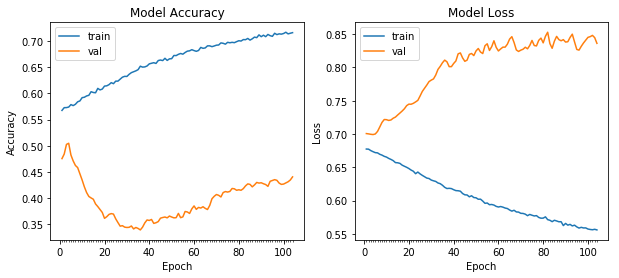

Accuracy using best model is: 0.68
Confusion Matrix Threshold: 0.4941980242729187
Model Eval Results:
*****************************
Confusion Matrix:
 [[89 15]
 [49  0]]
Precision: 0.0
Model Top Five Picks
 Avg rtn top 5: -0.0012
   true_value  pred_value  mkt_return   returns
0         0.0    0.513811    0.036537 -0.007216
1         0.0    0.513228    0.036537 -0.038804
2         0.0    0.501162    0.036537 -0.002379
3         0.0    0.501158    0.036537  0.009301
4         0.0    0.500123    0.036537  0.033333
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0039
   true_value  pred_value  mkt_return   returns
5         0.0    0.499954    0.036537 -0.026520
6         0.0    0.499570    0.036537 -0.004376
7         0.0    0.499385    0.036537  0.005088
8         0.0    0.498572    0.036537 -0.006136
9         0.0    0.497457    0.036537  0.012229
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0262
    true_value  pred_value  mkt_return   returns
10         0.0    0.497203    0.036537  0.006379
11    

Epoch 48/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.6051 - acc: 0.6638 - val_loss: 0.6677 - val_acc: 0.5543
Epoch 49/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.6026 - acc: 0.6677 - val_loss: 0.6680 - val_acc: 0.5571
Epoch 50/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.6035 - acc: 0.6690 - val_loss: 0.6704 - val_acc: 0.5568
Epoch 51/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.6018 - acc: 0.6699 - val_loss: 0.6707 - val_acc: 0.5546
Epoch 52/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.6007 - acc: 0.6719 - val_loss: 0.6737 - val_acc: 0.5540
Epoch 53/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.5980 - acc: 0.6727 - val_loss: 0.6721 - val_acc: 0.5602
Epoch 54/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5972 - acc: 0.6746 - val_loss: 0.6699 - val_acc: 0.5605
Epoch 55/1000
35343/

Epoch 107/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5378 - acc: 0.7285 - val_loss: 0.6185 - val_acc: 0.6467
Epoch 108/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.5382 - acc: 0.7288 - val_loss: 0.6191 - val_acc: 0.6617
Epoch 109/1000
35343/35343 [==============================] - 1s 42us/step - loss: 0.5358 - acc: 0.7317 - val_loss: 0.6133 - val_acc: 0.6636
Epoch 110/1000
35343/35343 [==============================] - 1s 42us/step - loss: 0.5348 - acc: 0.7345 - val_loss: 0.6142 - val_acc: 0.6539
Epoch 111/1000
35343/35343 [==============================] - 1s 40us/step - loss: 0.5361 - acc: 0.7336 - val_loss: 0.6248 - val_acc: 0.6474
Epoch 112/1000
35343/35343 [==============================] - 1s 41us/step - loss: 0.5322 - acc: 0.7353 - val_loss: 0.6238 - val_acc: 0.6505
Epoch 113/1000
35343/35343 [==============================] - 1s 41us/step - loss: 0.5353 - acc: 0.7329 - val_loss: 0.6137 - val_acc: 0.6639
Epoch 114/100

Epoch 165/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4940 - acc: 0.7602 - val_loss: 0.6011 - val_acc: 0.6458
Epoch 166/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4959 - acc: 0.7600 - val_loss: 0.5981 - val_acc: 0.6716
Epoch 167/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4938 - acc: 0.7624 - val_loss: 0.5985 - val_acc: 0.6688
Epoch 168/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4920 - acc: 0.7658 - val_loss: 0.6028 - val_acc: 0.6523
Epoch 169/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4967 - acc: 0.7605 - val_loss: 0.6029 - val_acc: 0.6611
Epoch 170/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4937 - acc: 0.7609 - val_loss: 0.6025 - val_acc: 0.6654
Epoch 171/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4930 - acc: 0.7642 - val_loss: 0.6013 - val_acc: 0.6505
Epoch 172/100

Epoch 223/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4694 - acc: 0.7788 - val_loss: 0.5967 - val_acc: 0.6552

Epoch 00223: ReduceLROnPlateau reducing learning rate to 0.0001310720108449459.
Epoch 224/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4687 - acc: 0.7792 - val_loss: 0.5972 - val_acc: 0.6558
Epoch 225/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4680 - acc: 0.7791 - val_loss: 0.5968 - val_acc: 0.6548
Epoch 226/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4679 - acc: 0.7781 - val_loss: 0.5967 - val_acc: 0.6539
Epoch 227/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4694 - acc: 0.7782 - val_loss: 0.5952 - val_acc: 0.6564
Epoch 228/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4682 - acc: 0.7794 - val_loss: 0.5942 - val_acc: 0.6626
Epoch 229/1000
35343/35343 [==============================] - 1s 38us/ste

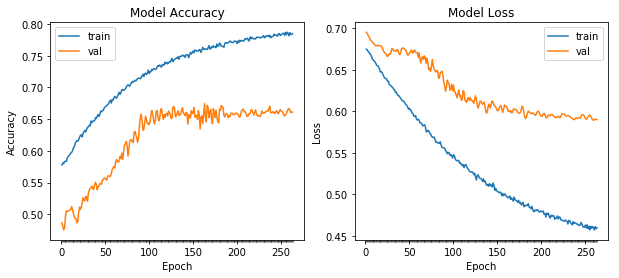

Accuracy using best model is: 0.73
Confusion Matrix Threshold: 0.5611329078674316
Model Eval Results:
*****************************
Confusion Matrix:
 [[103   8]
 [ 35   7]]
Precision: 0.4667
Model Top Five Picks
 Avg rtn top 5: 0.0226
   true_value  pred_value  mkt_return   returns
0         0.0    0.844455    0.014822  0.001641
1         0.0    0.804564    0.014822  0.014659
2         1.0    0.681236    0.014822  0.075035
3         0.0    0.680244    0.014822  0.014351
4         0.0    0.667171    0.014822  0.007299
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0062
   true_value  pred_value  mkt_return   returns
5         1.0    0.647651    0.014822  0.015203
6         1.0    0.625923    0.014822  0.051096
7         0.0    0.606171    0.014822 -0.043677
8         0.0    0.594583    0.014822  0.000439
9         0.0    0.594251    0.014822 -0.053997
Model 3rd Five Picks
 Avg rtn 3rd 5: 0.0326
    true_value  pred_value  mkt_return   returns
10         1.0    0.588158    0.014822  0.018803
1

Epoch 48/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4717 - acc: 0.7783 - val_loss: 0.6406 - val_acc: 0.6113
Epoch 49/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4661 - acc: 0.7804 - val_loss: 0.6272 - val_acc: 0.6237
Epoch 50/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4667 - acc: 0.7801 - val_loss: 0.6162 - val_acc: 0.6349
Epoch 51/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4686 - acc: 0.7800 - val_loss: 0.6359 - val_acc: 0.6156
Epoch 52/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4693 - acc: 0.7766 - val_loss: 0.6483 - val_acc: 0.6013
Epoch 53/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4689 - acc: 0.7796 - val_loss: 0.6231 - val_acc: 0.6256
Epoch 54/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4665 - acc: 0.7795 - val_loss: 0.6172 - val_acc: 0.6312
Epoch 55/1000
35343/

Epoch 106/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4422 - acc: 0.7964 - val_loss: 0.6196 - val_acc: 0.6471
Epoch 107/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4436 - acc: 0.7948 - val_loss: 0.6249 - val_acc: 0.6418
Epoch 108/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4444 - acc: 0.7939 - val_loss: 0.6197 - val_acc: 0.6452
Epoch 109/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4434 - acc: 0.7949 - val_loss: 0.6231 - val_acc: 0.6405
Epoch 110/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4430 - acc: 0.7933 - val_loss: 0.6251 - val_acc: 0.6393
Epoch 111/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4371 - acc: 0.7970 - val_loss: 0.6167 - val_acc: 0.6452
Epoch 112/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4414 - acc: 0.7951 - val_loss: 0.6139 - val_acc: 0.6492
Epoch 113/100

Epoch 164/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4195 - acc: 0.8076 - val_loss: 0.6287 - val_acc: 0.6461
Epoch 165/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4205 - acc: 0.8075 - val_loss: 0.6316 - val_acc: 0.6436
Epoch 166/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4173 - acc: 0.8094 - val_loss: 0.6302 - val_acc: 0.6461
Epoch 167/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4178 - acc: 0.8097 - val_loss: 0.6303 - val_acc: 0.6464
Epoch 168/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4179 - acc: 0.8086 - val_loss: 0.6277 - val_acc: 0.6486
Epoch 169/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4196 - acc: 0.8099 - val_loss: 0.6157 - val_acc: 0.6561
Epoch 170/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4183 - acc: 0.8098 - val_loss: 0.6185 - val_acc: 0.6542
Epoch 171/100

Epoch 222/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4075 - acc: 0.8159 - val_loss: 0.6328 - val_acc: 0.6499
Epoch 223/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4052 - acc: 0.8182 - val_loss: 0.6300 - val_acc: 0.6520
Epoch 224/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4061 - acc: 0.8149 - val_loss: 0.6261 - val_acc: 0.6555
Epoch 225/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4061 - acc: 0.8170 - val_loss: 0.6262 - val_acc: 0.6555
Epoch 226/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4049 - acc: 0.8195 - val_loss: 0.6272 - val_acc: 0.6520
Epoch 227/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4059 - acc: 0.8185 - val_loss: 0.6335 - val_acc: 0.6483
Epoch 228/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4047 - acc: 0.8179 - val_loss: 0.6409 - val_acc: 0.6408
Epoch 229/100

Epoch 280/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.3953 - acc: 0.8237 - val_loss: 0.6462 - val_acc: 0.6483
Epoch 281/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.3997 - acc: 0.8230 - val_loss: 0.6361 - val_acc: 0.6511
Epoch 282/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.3974 - acc: 0.8232 - val_loss: 0.6294 - val_acc: 0.6564
Epoch 283/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.3956 - acc: 0.8228 - val_loss: 0.6286 - val_acc: 0.6576

Epoch 00283: ReduceLROnPlateau reducing learning rate to 6.710886955261231e-05.
Epoch 284/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.3971 - acc: 0.8209 - val_loss: 0.6308 - val_acc: 0.6555
Epoch 285/1000
35343/35343 [==============================] - 1s 30us/step - loss: 0.3973 - acc: 0.8217 - val_loss: 0.6320 - val_acc: 0.6564
Epoch 286/1000
35343/35343 [==============================] - 1s 35us/ste

Epoch 338/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.3930 - acc: 0.8260 - val_loss: 0.6260 - val_acc: 0.6592

Epoch 00338: ReduceLROnPlateau reducing learning rate to 5.3687096806243065e-05.
Epoch 339/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.3912 - acc: 0.8263 - val_loss: 0.6253 - val_acc: 0.6604
Epoch 340/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.3871 - acc: 0.8277 - val_loss: 0.6283 - val_acc: 0.6586
Epoch 341/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.3891 - acc: 0.8268 - val_loss: 0.6307 - val_acc: 0.6586
Epoch 342/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.3900 - acc: 0.8273 - val_loss: 0.6308 - val_acc: 0.6595
Epoch 343/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.3895 - acc: 0.8280 - val_loss: 0.6301 - val_acc: 0.6595
Epoch 344/1000
35343/35343 [==============================] - 1s 31us/st

Epoch 395/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.3858 - acc: 0.8305 - val_loss: 0.6288 - val_acc: 0.6586
Epoch 396/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.3889 - acc: 0.8265 - val_loss: 0.6312 - val_acc: 0.6592
Epoch 397/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.3863 - acc: 0.8300 - val_loss: 0.6347 - val_acc: 0.6583
Epoch 398/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.3843 - acc: 0.8303 - val_loss: 0.6364 - val_acc: 0.6583
Epoch 399/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.3855 - acc: 0.8310 - val_loss: 0.6351 - val_acc: 0.6598
Epoch 400/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.3847 - acc: 0.8320 - val_loss: 0.6317 - val_acc: 0.6604
Epoch 401/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.3845 - acc: 0.8292 - val_loss: 0.6274 - val_acc: 0.6573
Epoch 402/100

Epoch 452/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.3850 - acc: 0.8295 - val_loss: 0.6346 - val_acc: 0.6583
Epoch 453/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.3820 - acc: 0.8306 - val_loss: 0.6360 - val_acc: 0.6567
Epoch 454/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.3805 - acc: 0.8312 - val_loss: 0.6374 - val_acc: 0.6573
Epoch 455/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.3853 - acc: 0.8296 - val_loss: 0.6368 - val_acc: 0.6567
Epoch 456/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.3815 - acc: 0.8348 - val_loss: 0.6356 - val_acc: 0.6564
Epoch 457/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.3802 - acc: 0.8315 - val_loss: 0.6343 - val_acc: 0.6586
Epoch 458/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.3804 - acc: 0.8324 - val_loss: 0.6336 - val_acc: 0.6595
Epoch 459/100

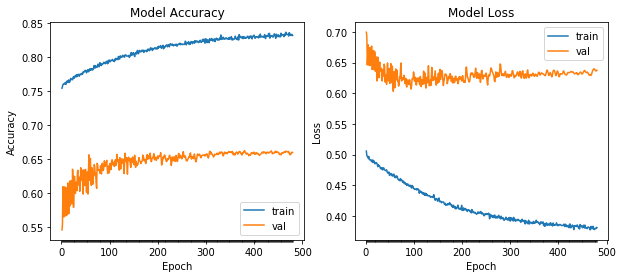

Accuracy using best model is: 0.76
Confusion Matrix Threshold: 0.7751259207725525
Model Eval Results:
*****************************
Confusion Matrix:
 [[107  12]
 [ 31   3]]
Precision: 0.2
Model Top Five Picks
 Avg rtn top 5: 0.0133
   true_value  pred_value  mkt_return   returns
0         0.0    0.947056    0.018487  0.008657
1         0.0    0.918334    0.018487  0.004588
2         1.0    0.863813    0.018487  0.071751
3         0.0    0.836901    0.018487 -0.035922
4         0.0    0.832076    0.018487  0.017258
Model 2nd Five Picks
 Avg rtn 2nd 5: 0.0054
   true_value  pred_value  mkt_return   returns
5         1.0    0.831378    0.018487  0.036677
6         0.0    0.831126    0.018487 -0.003276
7         0.0    0.828840    0.018487  0.015981
8         1.0    0.825895    0.018487  0.020975
9         0.0    0.818425    0.018487 -0.043342
Model 3rd Five Picks
 Avg rtn 3rd 5: 0.0039
    true_value  pred_value  mkt_return   returns
10         0.0    0.817909    0.018487  0.005280
11   

Epoch 47/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4779 - acc: 0.7707 - val_loss: 0.6542 - val_acc: 0.6218
Epoch 48/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4785 - acc: 0.7742 - val_loss: 0.6769 - val_acc: 0.6029
Epoch 49/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4775 - acc: 0.7728 - val_loss: 0.6717 - val_acc: 0.6054
Epoch 50/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4793 - acc: 0.7696 - val_loss: 0.6597 - val_acc: 0.6128
Epoch 51/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4746 - acc: 0.7740 - val_loss: 0.6622 - val_acc: 0.6088
Epoch 52/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4765 - acc: 0.7751 - val_loss: 0.6604 - val_acc: 0.6088
Epoch 53/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4790 - acc: 0.7698 - val_loss: 0.6521 - val_acc: 0.6200
Epoch 54/1000
35343/

Epoch 105/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4572 - acc: 0.7868 - val_loss: 0.6638 - val_acc: 0.6054
Epoch 106/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4535 - acc: 0.7876 - val_loss: 0.6765 - val_acc: 0.5951
Epoch 107/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4597 - acc: 0.7833 - val_loss: 0.6856 - val_acc: 0.5885
Model took 132.10 seconds to train
Accuracy on test data is: 0.40


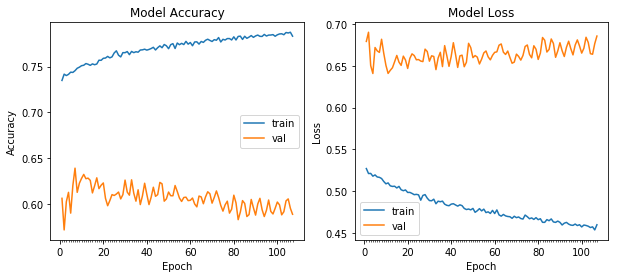

Accuracy using best model is: 0.38
Confusion Matrix Threshold: 0.9536565542221069
Model Eval Results:
*****************************
Confusion Matrix:
 [[65 14]
 [73  1]]
Precision: 0.0667
Model Top Five Picks
 Avg rtn top 5: 0.0131
   true_value  pred_value  mkt_return   returns
0         1.0    0.963134    0.043916  0.065003
1         0.0    0.960643    0.043916  0.001632
2         0.0    0.960552    0.043916 -0.003602
3         0.0    0.959924    0.043916 -0.000549
4         0.0    0.959416    0.043916  0.003214
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0016
   true_value  pred_value  mkt_return   returns
5         0.0    0.957557    0.043916 -0.001085
6         0.0    0.956538    0.043916  0.000835
7         0.0    0.955819    0.043916 -0.002188
8         0.0    0.955810    0.043916 -0.003595
9         0.0    0.955721    0.043916 -0.002014
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0022
    true_value  pred_value  mkt_return   returns
10         0.0    0.955429    0.043916 -0.004592
11  

Epoch 48/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4916 - acc: 0.7643 - val_loss: 0.9887 - val_acc: 0.4273
Epoch 49/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4909 - acc: 0.7655 - val_loss: 0.9829 - val_acc: 0.4295
Epoch 50/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4935 - acc: 0.7637 - val_loss: 1.0206 - val_acc: 0.4080
Epoch 51/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4902 - acc: 0.7654 - val_loss: 1.0239 - val_acc: 0.4105
Epoch 52/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.4921 - acc: 0.7642 - val_loss: 0.9814 - val_acc: 0.4370
Epoch 53/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4912 - acc: 0.7639 - val_loss: 1.0406 - val_acc: 0.4090
Epoch 54/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4873 - acc: 0.7664 - val_loss: 1.0233 - val_acc: 0.4189
Epoch 55/1000
35343/

Epoch 107/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4583 - acc: 0.7862 - val_loss: 1.0063 - val_acc: 0.4656
Epoch 108/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4582 - acc: 0.7859 - val_loss: 1.0245 - val_acc: 0.4469
Epoch 109/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4609 - acc: 0.7862 - val_loss: 1.0303 - val_acc: 0.4410
Epoch 110/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4582 - acc: 0.7871 - val_loss: 1.0168 - val_acc: 0.4460
Epoch 111/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4572 - acc: 0.7868 - val_loss: 1.0655 - val_acc: 0.4230
Epoch 112/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4567 - acc: 0.7860 - val_loss: 1.0286 - val_acc: 0.4482
Epoch 113/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4542 - acc: 0.7881 - val_loss: 1.0253 - val_acc: 0.4547
Epoch 114/100

Epoch 165/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4340 - acc: 0.8015 - val_loss: 1.1214 - val_acc: 0.4264
Epoch 166/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4305 - acc: 0.7988 - val_loss: 1.0903 - val_acc: 0.4423
Epoch 167/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4306 - acc: 0.8038 - val_loss: 1.0732 - val_acc: 0.4504
Epoch 168/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4325 - acc: 0.8019 - val_loss: 1.0790 - val_acc: 0.4463
Epoch 169/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4335 - acc: 0.8014 - val_loss: 1.0828 - val_acc: 0.4373
Epoch 170/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4340 - acc: 0.7995 - val_loss: 1.0880 - val_acc: 0.4320
Epoch 171/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4313 - acc: 0.8036 - val_loss: 1.1026 - val_acc: 0.4202
Epoch 172/100

Epoch 222/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4222 - acc: 0.8073 - val_loss: 1.1090 - val_acc: 0.4370
Epoch 223/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4169 - acc: 0.8115 - val_loss: 1.0954 - val_acc: 0.4407
Epoch 224/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4198 - acc: 0.8087 - val_loss: 1.1105 - val_acc: 0.4401
Epoch 225/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4160 - acc: 0.8106 - val_loss: 1.1324 - val_acc: 0.4348
Epoch 226/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4154 - acc: 0.8100 - val_loss: 1.1197 - val_acc: 0.4385
Epoch 227/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4185 - acc: 0.8086 - val_loss: 1.1102 - val_acc: 0.4448
Epoch 228/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4152 - acc: 0.8130 - val_loss: 1.1236 - val_acc: 0.4317
Epoch 229/100

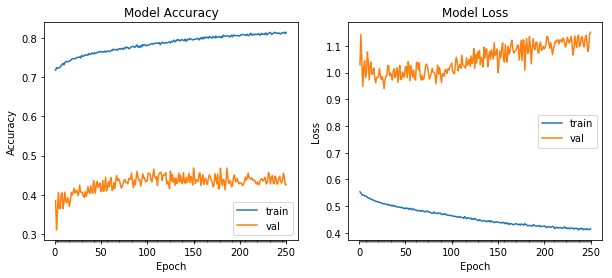

Accuracy using best model is: 0.57
Confusion Matrix Threshold: 0.966052770614624
Model Eval Results:
*****************************
Confusion Matrix:
 [[79  2]
 [59 13]]
Precision: 0.8667
Model Top Five Picks
 Avg rtn top 5: -0.0083
   true_value  pred_value  mkt_return   returns
0         1.0    0.982933   -0.014782 -0.010541
1         1.0    0.981150   -0.014782 -0.001240
2         1.0    0.980877   -0.014782  0.000180
3         1.0    0.978160   -0.014782 -0.007356
4         0.0    0.977111   -0.014782 -0.022566
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0051
   true_value  pred_value  mkt_return   returns
5         1.0    0.975237   -0.014782 -0.003403
6         1.0    0.975148   -0.014782 -0.007603
7         1.0    0.974348   -0.014782 -0.001512
8         1.0    0.973712   -0.014782  0.000907
9         1.0    0.971880   -0.014782 -0.013745
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0089
    true_value  pred_value  mkt_return   returns
10         1.0    0.969119   -0.014782 -0.013566
11  

Epoch 47/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5097 - acc: 0.7512 - val_loss: 0.8238 - val_acc: 0.5117
Epoch 48/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.5091 - acc: 0.7497 - val_loss: 0.8266 - val_acc: 0.5135
Epoch 49/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.5100 - acc: 0.7499 - val_loss: 0.8274 - val_acc: 0.5132
Epoch 50/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5092 - acc: 0.7500 - val_loss: 0.8290 - val_acc: 0.5104
Epoch 51/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5076 - acc: 0.7532 - val_loss: 0.8285 - val_acc: 0.5082
Epoch 52/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5063 - acc: 0.7529 - val_loss: 0.8301 - val_acc: 0.5058
Epoch 53/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5052 - acc: 0.7533 - val_loss: 0.8333 - val_acc: 0.5036
Epoch 54/1000
35343/

Epoch 105/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4805 - acc: 0.7704 - val_loss: 0.8509 - val_acc: 0.5086
Epoch 106/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4813 - acc: 0.7694 - val_loss: 0.8535 - val_acc: 0.5070
Epoch 107/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4804 - acc: 0.7708 - val_loss: 0.8551 - val_acc: 0.5058
Epoch 108/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4803 - acc: 0.7713 - val_loss: 0.8555 - val_acc: 0.5033
Epoch 109/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4780 - acc: 0.7716 - val_loss: 0.8554 - val_acc: 0.5076
Epoch 110/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4777 - acc: 0.7718 - val_loss: 0.8561 - val_acc: 0.5098
Epoch 111/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4797 - acc: 0.7722 - val_loss: 0.8534 - val_acc: 0.5142
Model took 14

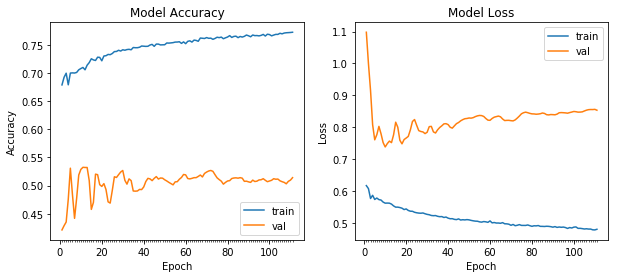

Accuracy using best model is: 0.70
Confusion Matrix Threshold: 0.8503915071487427
Model Eval Results:
*****************************
Confusion Matrix:
 [[102  12]
 [ 36   3]]
Precision: 0.2
Model Top Five Picks
 Avg rtn top 5: -0.0124
   true_value  pred_value  mkt_return   returns
0         0.0    0.934565    0.017953 -0.018748
1         0.0    0.933047    0.017953 -0.038034
2         0.0    0.926038    0.017953 -0.003029
3         0.0    0.925026    0.017953 -0.004348
4         0.0    0.922090    0.017953  0.002007
Model 2nd Five Picks
 Avg rtn 2nd 5: 0.003
   true_value  pred_value  mkt_return   returns
5         0.0    0.911567    0.017953  0.009169
6         0.0    0.909070    0.017953 -0.008591
7         0.0    0.899324    0.017953 -0.003217
8         1.0    0.896803    0.017953  0.018685
9         0.0    0.880410    0.017953 -0.001136
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0027
    true_value  pred_value  mkt_return   returns
10         0.0    0.869058    0.017953 -0.066834
11  

Epoch 47/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.5300 - acc: 0.7388 - val_loss: 0.7890 - val_acc: 0.4706
Epoch 48/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5316 - acc: 0.7315 - val_loss: 0.7878 - val_acc: 0.4756
Epoch 49/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.5299 - acc: 0.7371 - val_loss: 0.7859 - val_acc: 0.4818
Epoch 50/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5269 - acc: 0.7377 - val_loss: 0.7849 - val_acc: 0.4821
Epoch 51/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5275 - acc: 0.7379 - val_loss: 0.7855 - val_acc: 0.4805
Epoch 52/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5283 - acc: 0.7373 - val_loss: 0.7858 - val_acc: 0.4790
Epoch 53/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5260 - acc: 0.7397 - val_loss: 0.7865 - val_acc: 0.4784
Epoch 54/1000
35343/

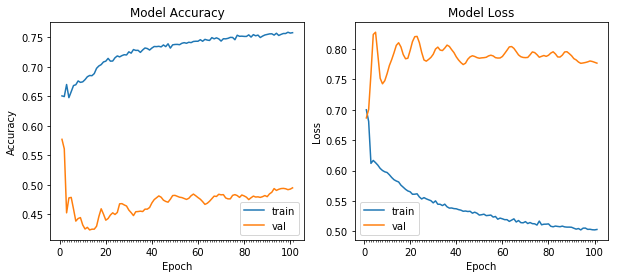

Accuracy using best model is: 0.28
Confusion Matrix Threshold: 0.9098790287971497
Model Eval Results:
*****************************
Confusion Matrix:
 [[ 22   2]
 [116  13]]
Precision: 0.8667
Model Top Five Picks
 Avg rtn top 5: -0.003
   true_value  pred_value  mkt_return   returns
0         1.0    0.961516   -0.044343 -0.001802
1         1.0    0.960088   -0.044343 -0.009470
2         1.0    0.958637   -0.044343  0.000643
3         1.0    0.948341   -0.044343 -0.024119
4         1.0    0.944298   -0.044343  0.019814
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0202
   true_value  pred_value  mkt_return   returns
5         1.0    0.943691   -0.044343 -0.036757
6         0.0    0.942899   -0.044343 -0.050612
7         1.0    0.936180   -0.044343 -0.032700
8         1.0    0.929428   -0.044343  0.006993
9         1.0    0.928420   -0.044343  0.012014
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0463
    true_value  pred_value  mkt_return   returns
10         1.0    0.914001   -0.044343 -0.036681


Epoch 48/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.5612 - acc: 0.7078 - val_loss: 0.6313 - val_acc: 0.6573
Epoch 49/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.5609 - acc: 0.7091 - val_loss: 0.6303 - val_acc: 0.6558
Epoch 50/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5579 - acc: 0.7097 - val_loss: 0.6301 - val_acc: 0.6552
Epoch 51/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5570 - acc: 0.7102 - val_loss: 0.6294 - val_acc: 0.6520
Epoch 52/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5581 - acc: 0.7094 - val_loss: 0.6281 - val_acc: 0.6536
Epoch 53/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.5562 - acc: 0.7130 - val_loss: 0.6283 - val_acc: 0.6533
Epoch 54/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.5539 - acc: 0.7150 - val_loss: 0.6326 - val_acc: 0.6502
Epoch 55/1000
35343/

Epoch 106/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.5214 - acc: 0.7381 - val_loss: 0.6243 - val_acc: 0.6676
Epoch 107/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5229 - acc: 0.7369 - val_loss: 0.6241 - val_acc: 0.6676
Epoch 108/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5221 - acc: 0.7390 - val_loss: 0.6243 - val_acc: 0.6667
Epoch 109/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5230 - acc: 0.7411 - val_loss: 0.6253 - val_acc: 0.6642
Epoch 110/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5174 - acc: 0.7423 - val_loss: 0.6240 - val_acc: 0.6642
Epoch 111/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5185 - acc: 0.7421 - val_loss: 0.6227 - val_acc: 0.6608
Epoch 112/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.5194 - acc: 0.7407 - val_loss: 0.6250 - val_acc: 0.6611
Epoch 113/100

Epoch 163/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4973 - acc: 0.7580 - val_loss: 0.6298 - val_acc: 0.6598
Epoch 164/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4988 - acc: 0.7541 - val_loss: 0.6311 - val_acc: 0.6598
Epoch 165/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4991 - acc: 0.7560 - val_loss: 0.6318 - val_acc: 0.6576
Epoch 166/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5011 - acc: 0.7554 - val_loss: 0.6320 - val_acc: 0.6542
Epoch 167/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4975 - acc: 0.7544 - val_loss: 0.6313 - val_acc: 0.6536
Epoch 168/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.5022 - acc: 0.7534 - val_loss: 0.6303 - val_acc: 0.6564
Epoch 169/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4990 - acc: 0.7525 - val_loss: 0.6302 - val_acc: 0.6570
Epoch 170/100

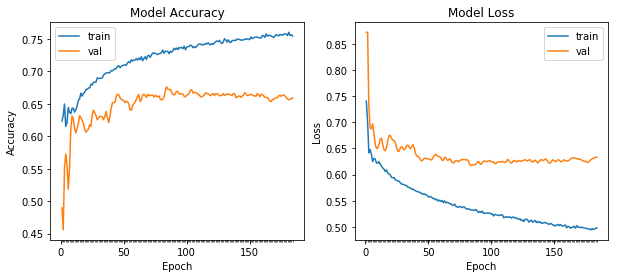

Accuracy using best model is: 0.74
Confusion Matrix Threshold: 0.7802287936210632
Model Eval Results:
*****************************
Confusion Matrix:
 [[101  11]
 [ 37   4]]
Precision: 0.2667
Model Top Five Picks
 Avg rtn top 5: 0.0373
   true_value  pred_value  mkt_return   returns
0         1.0    0.922112    0.022764  0.031170
1         1.0    0.866755    0.022764  0.165432
2         0.0    0.837121    0.022764 -0.044545
3         0.0    0.834197    0.022764 -0.030627
4         1.0    0.821352    0.022764  0.065178
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0173
   true_value  pred_value  mkt_return   returns
5         1.0    0.814135    0.022764  0.045123
6         0.0    0.801678    0.022764 -0.054136
7         0.0    0.799120    0.022764 -0.017134
8         0.0    0.798065    0.022764 -0.049959
9         0.0    0.794633    0.022764 -0.010277
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0394
    true_value  pred_value  mkt_return   returns
10         0.0    0.792384    0.022764 -0.164500


Epoch 48/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5151 - acc: 0.7446 - val_loss: 0.6586 - val_acc: 0.6390
Epoch 49/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.5159 - acc: 0.7429 - val_loss: 0.6574 - val_acc: 0.6396
Epoch 50/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5126 - acc: 0.7473 - val_loss: 0.6583 - val_acc: 0.6396
Epoch 51/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5120 - acc: 0.7462 - val_loss: 0.6615 - val_acc: 0.6346
Epoch 52/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.5166 - acc: 0.7426 - val_loss: 0.6634 - val_acc: 0.6377
Epoch 53/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.5138 - acc: 0.7452 - val_loss: 0.6649 - val_acc: 0.6355
Epoch 54/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5149 - acc: 0.7442 - val_loss: 0.6659 - val_acc: 0.6359
Epoch 55/1000
35343/

Epoch 106/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4910 - acc: 0.7585 - val_loss: 0.6725 - val_acc: 0.6318
Epoch 107/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4937 - acc: 0.7600 - val_loss: 0.6740 - val_acc: 0.6303
Epoch 108/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4919 - acc: 0.7603 - val_loss: 0.6735 - val_acc: 0.6312
Epoch 109/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4915 - acc: 0.7596 - val_loss: 0.6718 - val_acc: 0.6309
Epoch 110/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4926 - acc: 0.7601 - val_loss: 0.6709 - val_acc: 0.6290
Epoch 111/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4902 - acc: 0.7625 - val_loss: 0.6698 - val_acc: 0.6306

Epoch 00111: ReduceLROnPlateau reducing learning rate to 0.00010485760867595673.
Epoch 112/1000
35343/35343 [==============================] - 1s 37us/st

Epoch 163/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4779 - acc: 0.7695 - val_loss: 0.6748 - val_acc: 0.6343
Epoch 164/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4782 - acc: 0.7693 - val_loss: 0.6738 - val_acc: 0.6365
Epoch 165/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4750 - acc: 0.7694 - val_loss: 0.6719 - val_acc: 0.6365
Epoch 166/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4782 - acc: 0.7669 - val_loss: 0.6713 - val_acc: 0.6374
Epoch 167/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4792 - acc: 0.7684 - val_loss: 0.6713 - val_acc: 0.6362
Epoch 168/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4772 - acc: 0.7691 - val_loss: 0.6727 - val_acc: 0.6352
Epoch 169/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4769 - acc: 0.7703 - val_loss: 0.6744 - val_acc: 0.6346
Epoch 170/100

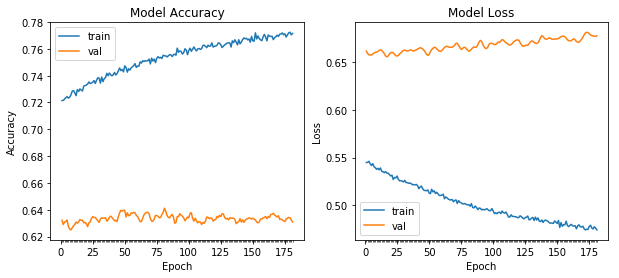

Accuracy using best model is: 0.78
Confusion Matrix Threshold: 0.822910726070404
Model Eval Results:
*****************************
Confusion Matrix:
 [[107  15]
 [ 31   0]]
Precision: 0.0
Model Top Five Picks
 Avg rtn top 5: 0.0119
   true_value  pred_value  mkt_return   returns
0         0.0    0.924195    0.039378  0.007129
1         0.0    0.913794    0.039378  0.006223
2         0.0    0.895563    0.039378  0.012457
3         0.0    0.873237    0.039378  0.029278
4         0.0    0.857138    0.039378  0.004487
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0087
   true_value  pred_value  mkt_return   returns
5         0.0    0.855216    0.039378  0.006450
6         0.0    0.853748    0.039378 -0.077409
7         0.0    0.845095    0.039378  0.004397
8         0.0    0.839756    0.039378  0.018256
9         0.0    0.838516    0.039378  0.004783
Model 3rd Five Picks
 Avg rtn 3rd 5: 0.001
    true_value  pred_value  mkt_return   returns
10         0.0    0.836446    0.039378  0.024290
11    

Epoch 47/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.5254 - acc: 0.7353 - val_loss: 0.9923 - val_acc: 0.3548
Epoch 48/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.5274 - acc: 0.7339 - val_loss: 1.0028 - val_acc: 0.3489
Epoch 49/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5268 - acc: 0.7376 - val_loss: 0.9996 - val_acc: 0.3501
Epoch 50/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5258 - acc: 0.7379 - val_loss: 0.9944 - val_acc: 0.3511
Epoch 51/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5255 - acc: 0.7372 - val_loss: 0.9909 - val_acc: 0.3536
Epoch 52/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.5271 - acc: 0.7353 - val_loss: 0.9952 - val_acc: 0.3529
Epoch 53/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.5245 - acc: 0.7378 - val_loss: 1.0037 - val_acc: 0.3489
Epoch 54/1000
35343/

Epoch 105/1000
35343/35343 [==============================] - 1s 39us/step - loss: 0.5054 - acc: 0.7502 - val_loss: 0.9751 - val_acc: 0.3978
Epoch 106/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5039 - acc: 0.7507 - val_loss: 0.9834 - val_acc: 0.3925
Epoch 107/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.5038 - acc: 0.7515 - val_loss: 1.0000 - val_acc: 0.3859
Epoch 108/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5047 - acc: 0.7488 - val_loss: 1.0058 - val_acc: 0.3806
Epoch 109/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5034 - acc: 0.7504 - val_loss: 0.9957 - val_acc: 0.3869
Epoch 110/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5052 - acc: 0.7499 - val_loss: 0.9852 - val_acc: 0.3937
Epoch 111/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5025 - acc: 0.7499 - val_loss: 0.9988 - val_acc: 0.3872
Epoch 112/100

Epoch 162/1000
35343/35343 [==============================] - 1s 30us/step - loss: 0.4889 - acc: 0.7605 - val_loss: 1.0085 - val_acc: 0.3797
Epoch 163/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4897 - acc: 0.7617 - val_loss: 1.0042 - val_acc: 0.3803
Epoch 164/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4920 - acc: 0.7597 - val_loss: 0.9984 - val_acc: 0.3822
Epoch 165/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4890 - acc: 0.7600 - val_loss: 0.9935 - val_acc: 0.3853
Epoch 166/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4875 - acc: 0.7629 - val_loss: 0.9941 - val_acc: 0.3881
Epoch 167/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4874 - acc: 0.7631 - val_loss: 0.9960 - val_acc: 0.3894
Epoch 168/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4870 - acc: 0.7607 - val_loss: 1.0014 - val_acc: 0.3881
Epoch 169/100

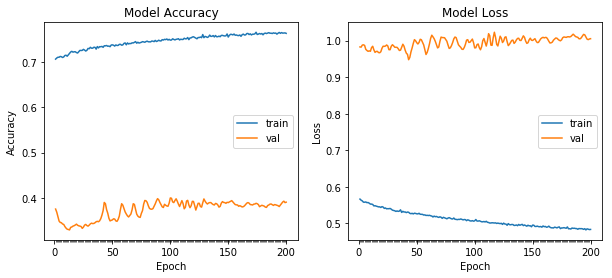

Accuracy using best model is: 0.63
Confusion Matrix Threshold: 0.7769518494606018
Model Eval Results:
*****************************
Confusion Matrix:
 [[87 10]
 [51  5]]
Precision: 0.3333
Model Top Five Picks
 Avg rtn top 5: 0.0357
   true_value  pred_value  mkt_return   returns
0         1.0    0.857687    0.006674  0.057552
1         0.0    0.848796    0.006674 -0.046723
2         1.0    0.836119    0.006674  0.011966
3         0.0    0.825520    0.006674 -0.008507
4         1.0    0.808682    0.006674  0.164132
Model 2nd Five Picks
 Avg rtn 2nd 5: -0.0259
   true_value  pred_value  mkt_return   returns
5         1.0    0.805624    0.006674  0.022205
6         0.0    0.802671    0.006674  0.006263
7         0.0    0.799850    0.006674 -0.009951
8         0.0    0.797299    0.006674 -0.051491
9         0.0    0.790792    0.006674 -0.096621
Model 3rd Five Picks
 Avg rtn 3rd 5: -0.0238
    true_value  pred_value  mkt_return   returns
10         0.0    0.786887    0.006674 -0.036752
11  

Epoch 48/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5195 - acc: 0.7419 - val_loss: 0.8709 - val_acc: 0.4223
Epoch 49/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5206 - acc: 0.7409 - val_loss: 0.8747 - val_acc: 0.4177
Epoch 50/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5190 - acc: 0.7425 - val_loss: 0.8781 - val_acc: 0.4161
Epoch 51/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.5191 - acc: 0.7401 - val_loss: 0.8787 - val_acc: 0.4183
Epoch 52/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.5175 - acc: 0.7434 - val_loss: 0.8726 - val_acc: 0.4214
Epoch 53/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.5176 - acc: 0.7413 - val_loss: 0.8824 - val_acc: 0.4167
Epoch 54/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.5168 - acc: 0.7435 - val_loss: 0.8980 - val_acc: 0.4021
Epoch 55/1000
35343/

Epoch 106/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4859 - acc: 0.7628 - val_loss: 0.9289 - val_acc: 0.4217
Epoch 107/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4854 - acc: 0.7645 - val_loss: 0.9208 - val_acc: 0.4276
Epoch 108/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4867 - acc: 0.7623 - val_loss: 0.9173 - val_acc: 0.4326
Epoch 109/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4858 - acc: 0.7632 - val_loss: 0.9212 - val_acc: 0.4311
Epoch 110/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4840 - acc: 0.7626 - val_loss: 0.9220 - val_acc: 0.4301
Epoch 111/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4862 - acc: 0.7623 - val_loss: 0.9174 - val_acc: 0.4298
Epoch 112/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4841 - acc: 0.7666 - val_loss: 0.9161 - val_acc: 0.4323
Epoch 113/100

Epoch 164/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4716 - acc: 0.7727 - val_loss: 0.9264 - val_acc: 0.4432
Epoch 165/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4680 - acc: 0.7745 - val_loss: 0.9455 - val_acc: 0.4342
Epoch 166/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4688 - acc: 0.7741 - val_loss: 0.9458 - val_acc: 0.4320
Epoch 167/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4664 - acc: 0.7738 - val_loss: 0.9377 - val_acc: 0.4364
Epoch 168/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4688 - acc: 0.7743 - val_loss: 0.9354 - val_acc: 0.4388
Epoch 169/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4660 - acc: 0.7749 - val_loss: 0.9383 - val_acc: 0.4360
Epoch 170/1000
35343/35343 [==============================] - 1s 38us/step - loss: 0.4661 - acc: 0.7776 - val_loss: 0.9415 - val_acc: 0.4357
Epoch 171/100

Epoch 222/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4529 - acc: 0.7867 - val_loss: 0.9541 - val_acc: 0.4398
Epoch 223/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4535 - acc: 0.7852 - val_loss: 0.9507 - val_acc: 0.4472
Epoch 224/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4558 - acc: 0.7843 - val_loss: 0.9550 - val_acc: 0.4441
Epoch 225/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4575 - acc: 0.7814 - val_loss: 0.9621 - val_acc: 0.4379
Epoch 226/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4558 - acc: 0.7849 - val_loss: 0.9622 - val_acc: 0.4360
Epoch 227/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4548 - acc: 0.7859 - val_loss: 0.9476 - val_acc: 0.4457
Epoch 228/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4526 - acc: 0.7866 - val_loss: 0.9332 - val_acc: 0.4535
Epoch 229/100

35343/35343 [==============================] - 1s 36us/step - loss: 0.4447 - acc: 0.7920 - val_loss: 0.9537 - val_acc: 0.4547
Epoch 281/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4465 - acc: 0.7898 - val_loss: 0.9592 - val_acc: 0.4519
Epoch 282/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4464 - acc: 0.7910 - val_loss: 0.9604 - val_acc: 0.4513
Epoch 283/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4452 - acc: 0.7917 - val_loss: 0.9497 - val_acc: 0.4563
Epoch 284/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4440 - acc: 0.7925 - val_loss: 0.9430 - val_acc: 0.4591
Epoch 285/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4461 - acc: 0.7899 - val_loss: 0.9474 - val_acc: 0.4553
Epoch 286/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4461 - acc: 0.7933 - val_loss: 0.9572 - val_acc: 0.4513

Epoch 00286: ReduceLROnPlat

35343/35343 [==============================] - 1s 36us/step - loss: 0.4402 - acc: 0.7939 - val_loss: 0.9573 - val_acc: 0.4556
Epoch 338/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4375 - acc: 0.7961 - val_loss: 0.9627 - val_acc: 0.4528
Epoch 339/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4346 - acc: 0.7980 - val_loss: 0.9725 - val_acc: 0.4488
Epoch 340/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4402 - acc: 0.7925 - val_loss: 0.9761 - val_acc: 0.4466
Epoch 341/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4381 - acc: 0.7945 - val_loss: 0.9714 - val_acc: 0.4476
Epoch 342/1000
35343/35343 [==============================] - 1s 37us/step - loss: 0.4350 - acc: 0.7961 - val_loss: 0.9611 - val_acc: 0.4532
Epoch 343/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4382 - acc: 0.7957 - val_loss: 0.9511 - val_acc: 0.4575
Epoch 344/1000
35343/35343 [

Epoch 396/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4321 - acc: 0.8013 - val_loss: 0.9556 - val_acc: 0.4678
Epoch 397/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4288 - acc: 0.8008 - val_loss: 0.9571 - val_acc: 0.4659
Epoch 398/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4296 - acc: 0.7996 - val_loss: 0.9585 - val_acc: 0.4659
Epoch 399/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4289 - acc: 0.8016 - val_loss: 0.9595 - val_acc: 0.4644
Epoch 400/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4330 - acc: 0.8000 - val_loss: 0.9570 - val_acc: 0.4644
Epoch 401/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4267 - acc: 0.8029 - val_loss: 0.9555 - val_acc: 0.4653
Epoch 402/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4296 - acc: 0.8019 - val_loss: 0.9530 - val_acc: 0.4656
Epoch 403/100

Epoch 454/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4289 - acc: 0.8033 - val_loss: 0.9567 - val_acc: 0.4656
Epoch 455/1000
35343/35343 [==============================] - 1s 32us/step - loss: 0.4262 - acc: 0.8039 - val_loss: 0.9536 - val_acc: 0.4659
Epoch 456/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4291 - acc: 0.8024 - val_loss: 0.9557 - val_acc: 0.4650
Epoch 457/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4248 - acc: 0.8042 - val_loss: 0.9594 - val_acc: 0.4641
Epoch 458/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4250 - acc: 0.8027 - val_loss: 0.9579 - val_acc: 0.4662
Epoch 459/1000
35343/35343 [==============================] - 1s 34us/step - loss: 0.4250 - acc: 0.8041 - val_loss: 0.9563 - val_acc: 0.4675
Epoch 460/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4261 - acc: 0.8040 - val_loss: 0.9525 - val_acc: 0.4703
Epoch 461/100

Epoch 512/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4217 - acc: 0.8065 - val_loss: 0.9564 - val_acc: 0.4728
Epoch 513/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4184 - acc: 0.8089 - val_loss: 0.9563 - val_acc: 0.4721
Epoch 514/1000
35343/35343 [==============================] - 1s 35us/step - loss: 0.4210 - acc: 0.8076 - val_loss: 0.9555 - val_acc: 0.4731
Epoch 515/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4210 - acc: 0.8072 - val_loss: 0.9556 - val_acc: 0.4731
Epoch 516/1000
35343/35343 [==============================] - 1s 33us/step - loss: 0.4200 - acc: 0.8071 - val_loss: 0.9566 - val_acc: 0.4731
Epoch 517/1000
35343/35343 [==============================] - 1s 31us/step - loss: 0.4193 - acc: 0.8082 - val_loss: 0.9574 - val_acc: 0.4728
Epoch 518/1000
35343/35343 [==============================] - 1s 36us/step - loss: 0.4213 - acc: 0.8078 - val_loss: 0.9604 - val_acc: 0.4715
Epoch 519/100

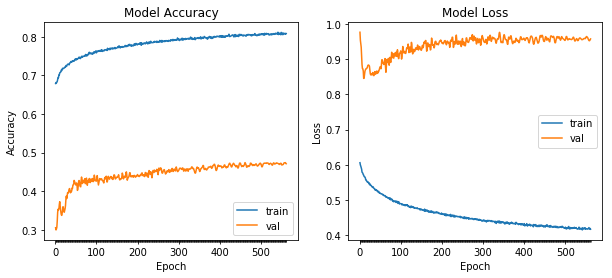

Accuracy using best model is: 0.81
Confusion Matrix Threshold: 0.7825309634208679
Model Eval Results:
*****************************
Confusion Matrix:
 [[112  12]
 [ 26   3]]
Precision: 0.2
Model Top Five Picks
 Avg rtn top 5: 0.0142
   true_value  pred_value  mkt_return   returns
0         0.0    0.850036    0.027376 -0.009022
1         0.0    0.839145    0.027376 -0.004768
2         0.0    0.831151    0.027376  0.007524
3         0.0    0.826982    0.027376 -0.014706
4         1.0    0.826152    0.027376  0.092049
Model 2nd Five Picks
 Avg rtn 2nd 5: 0.005
   true_value  pred_value  mkt_return   returns
5         0.0    0.823636    0.027376  0.002942
6         1.0    0.812891    0.027376  0.064360
7         0.0    0.812037    0.027376 -0.028942
8         0.0    0.806617    0.027376 -0.001107
9         0.0    0.805105    0.027376 -0.012308
Model 3rd Five Picks
 Avg rtn 3rd 5: 0.0142
    true_value  pred_value  mkt_return   returns
10         0.0    0.804480    0.027376  0.012281
11    

In [25]:
model_file = '/home/mvkrein/etf_model/code/mdl_wts_20180926_deep02.h5'
# model = load_model(model_file) #load previously created model for restart
# for i in range(dt2,dt_end,21): # use dt2 for restart
for i in range(dt1,dt_end,21): # use dt2 for restart
    print("Building model to predict for ",dates[i+273])
    x_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns] #train with 12 mos
    y_train = etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['target']] #train with 12 mos
#     x_eval = etf_data.loc[((etf_data['Date']>=dates[i+252]) & (etf_data['Date']<dates[i+273])),include_columns] #eval with 1 mos
#     y_eval = etf_data.loc[((etf_data['Date']>=dates[i+252]) & (etf_data['Date']<dates[i+273])),['rank_p_L-21']] #eval with 1 mos
#     x_train, x_eval, y_train, y_eval = train_test_split\
#     (etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),include_columns],\
#      etf_data.loc[((etf_data['Date']>=dates[i]) & (etf_data['Date']<dates[i+252])),['rank_p_L-21']],\
#      test_size=0.3, random_state=1234)
#     x_eval = x_train
#     y_eval = y_train
#predict one day
    x_test = etf_data.loc[(etf_data['Date']==dates[i+273]),include_columns] #predict one day-must be 21 days removed from training
    y_test = etf_data.loc[(etf_data['Date']==dates[i+273]),['target']] #predict if etf >= market
    returns = etf_data.loc[(etf_data['Date']==dates[i+273]),['delta_p_L-21']]
    mkt_return = etf_data.loc[(etf_data['Date']==dates[i+273]),['ivv_delta_p_L-21']]
    x_train_nmpy = x_train.as_matrix()
    y_train_nmpy = y_train.as_matrix()
#     x_eval_nmpy = x_eval.as_matrix()
#     y_eval_nmpy = y_eval.as_matrix()
    x_test_nmpy = x_test.as_matrix()
    y_test_nmpy = y_test.as_matrix()
    returns_nmpy = returns.as_matrix()
    mkt_return_nmpy = mkt_return.as_matrix()
    
    np.random.seed(54321)
    set_random_seed(54321)
    init = keras.initializers.glorot_uniform(54321)
    
    if i==dt1:
        model = Sequential()
        model.add(Dense(360, input_dim=360,kernel_initializer=init,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(360,kernel_initializer=init,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(360,kernel_initializer=init,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(90,kernel_initializer=init,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(10,kernel_initializer=init,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1,kernel_initializer=init,activation='sigmoid'))
#         Adm = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, decay=0.0)
        Adm = Adam(lr=0.0005)
        # Compile model
        model.compile(loss='binary_crossentropy', optimizer=Adm, metrics=['accuracy'])
#         model_file='/home/mvkrein/etf_model/code/weights-20180925_deep02-{epoch:02d}-{val_acc:.4f}.h5'
        earlyStopping = EarlyStopping(monitor='val_acc', patience=100, verbose=0, mode='auto')
        mcp_save = ModelCheckpoint(model_file, save_best_only=True,monitor='val_acc', mode='auto')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.8, patience=30, verbose=1, mode='auto')
#         model_info = model.fit(x_train_nmpy, y_train_nmpy, epochs=1000, verbose=1,batch_size=(len(symbols)*252),
#                 validation_split=(1/12),
#                 callbacks=[EarlyStopping(monitor='acc',patience=20)])
    #     model_info = model.fit(x_train_nmpy, y_train_nmpy, epochs=2000, verbose=1,batch_size=(len(symbols)*252),
    #               validation_data=(x_test_nmpy,y_test_nmpy),
    #               callbacks=[earlyStopping,mcp_save,reduce_lr_loss])
        start = time.time()
        model_info = model.fit(x_train_nmpy, y_train_nmpy, epochs=1000, verbose=1,batch_size=(len(symbols)*252),
              validation_split=(1/12),
              callbacks=[earlyStopping,mcp_save,reduce_lr_loss])
        end = time.time()
    else:
        start = time.time()
        model_info = model.fit(x_train_nmpy, y_train_nmpy, epochs=1000, verbose=1,batch_size=(len(symbols)*252),
                  validation_split=(1/12),
                  callbacks=[earlyStopping,mcp_save,reduce_lr_loss])
        end = time.time()
        
    print ("Model took %0.2f seconds to train"%(end - start))
    print ("Accuracy on test data is: %0.2f"%func_acc(x_test_nmpy, y_test_nmpy,0.9))
    
    plot_model_history(model_info)
    del model
    model = load_model(model_file)
    print ("Accuracy using best model is: %0.2f"%func_acc(x_test_nmpy, y_test_nmpy,0.9))
    
    y_pred_model = model.predict(x_test_nmpy)

    y_check = np.column_stack((y_test_nmpy, y_pred_model,mkt_return_nmpy,returns_nmpy))
    y_check_df = pd.DataFrame(y_check,columns=['true_value','pred_value','mkt_return','returns'])
    y_check_df.sort_values('pred_value',inplace=True,ascending=False)
    y_check_df.reset_index(inplace=True,drop=True)
    t_hold = y_check_df['pred_value'][14]
    print("Confusion Matrix Threshold:", t_hold)

    print('Model Eval Results:')
    print('*****************************')
    confusion = confusion_matrix(y_test_nmpy, (y_pred_model>=t_hold).astype(int))
#     fpr, tpr, thresholds = roc_curve(y_test_nmpy, (y_model_array>0.5).astype(int), pos_label=1)
    precision = confusion[1,1]/(confusion[1,1]+confusion[0,1])
    print('Confusion Matrix:\n',confusion)
    print('Precision:',round(precision,4))
    print("Model Top Five Picks")
    print(" Avg rtn top 5:", round(y_check_df['returns'][0:5].mean(),4))
    print(y_check_df.head(5))
    print("Model 2nd Five Picks")
    print(" Avg rtn 2nd 5:", round(y_check_df['returns'][5:10].mean(),4))
    print(y_check_df.iloc[5:10,])
    print("Model 3rd Five Picks")
    print(" Avg rtn 3rd 5:", round(y_check_df['returns'][10:15].mean(),4))
    print(y_check_df.iloc[10:15,])    
    print("Model Bottom Five Picks")
    print(" Avg rtn bottom 5:", round(y_check_df['returns'][-5:].mean(),4))
    print(y_check_df.tail(5))
    print('********************************************************')
    if i == dt1:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file)
    else:
        predict_data = etf_data.loc[(etf_data['Date']==dates[i+273]),['Date','sym','rank_p_L-21']]
        predict_data['predict'] = y_pred_model
        predict_data.to_csv(etf_predict_file,header=False,mode='a')